## Due to dependency issues, the sonar version must be 0.2.1 and fairseq2 version must be 0.2.1

In [ ]:
# !pip install fairseq2==0.2.1 sonar-space==0.2.1


In [ ]:
# import time
# start_time = time.time()

# from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
# text2vec = TextToEmbeddingModelPipeline(
#     encoder="text_sonar_basic_encoder", tokenizer="text_sonar_basic_encoder"
# )
# end_time = time.time()

# print(f"Importing SONAR and initializing took {end_time-start_time:.4f} seconds.")

In [ ]:
# examples = ['मुन मुत खाको चोर हरु गूठी सकेनन् ।', 'कमिसन खोरी हरु बाटो खोजी रहे लाटा बुजे लाजमर्दो तर्क नगर चोर हरु ।']
# examples_embedding= text2vec.predict(examples, source_lang="npi_Deva")
# print(examples_embedding.shape)
# print(examples_embedding)

so each sentence will have dimensions of 1024 features.

## Preparing Dataset

In [ ]:
!wget https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv

--2025-01-15 12:14:38--  https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467029 (456K) [text/plain]
Saving to: ‘Cleaned_Nepali_dataset.csv’

Cleaned_Nepali_data 100%[===================>] 456.08K  --.-KB/s    in 0.006s  

2025-01-15 12:14:39 (69.1 MB/s) - ‘Cleaned_Nepali_dataset.csv’ saved [467029/467029]



In [ ]:
import pandas as pd
import numpy as np

filepath= "/content/Cleaned_Nepali_dataset.csv"
df= pd.read_csv(filepath)
df.head()

,Text,Target
0,गुठी विधेक ल्याएर ठमेल राज गुठि जग्गा छाया सेन...,0
1,दले देश सकेछन बेचे खान सुरू गरेछन दले लखेटनु पछ ।,1
2,नेपाल ससकृती ध्वस्त पार्ने योजना !,1
3,मठ मन्दिर गुम्बा जग्गा हरु भुमाफिया नजर परे हु...,1
4,नेपाल कल कर्खाना नदि नाला बेची सके मठ मन्दीर ब...,1


In [ ]:
# Setting up torch

import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Setting default device to what's available
torch.set_default_device(device)

Using cpu device


In [ ]:
# # Splitting the dataset

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Target'], test_size=0.2, random_state=42)


In [ ]:
# # Get embeddings for training and testing datasets
# X_train_embeddings = text2vec.predict(X_train.tolist(), source_lang="npi_Deva")
# X_test_embeddings = text2vec.predict(X_test.tolist(), source_lang="npi_Deva")

# print(X_train_embeddings[:5])

In [ ]:
# # Check the shape of the embeddings and labels
# print(X_train_embeddings.shape)  # Should be (num_samples, 1024)
# print(X_test_embeddings.shape)   # Should be (num_samples, 1024)
# print(torch.tensor(y_train.values).shape)  # Labels tensor
# print(torch.tensor(y_test.values).shape)   # Labels tensor

# # Saving as obtaining embeddings took 43 mins
# torch.save(X_train_embeddings, 'X_train_embeddings.pt')
# torch.save(X_test_embeddings, 'X_test_embeddings.pt')
# torch.save(torch.tensor(y_train.values), 'y_train_tensor.pt')
# torch.save(torch.tensor(y_test.values), 'y_test_tensor.pt')

## The embeddings are saved as tensors which can be loaded as

In [ ]:
X_train_sonar= torch.load('X_train_embeddings.pt')
X_test_sonar= torch.load('X_test_embeddings.pt')
y_train_sonar= torch.load('y_train_tensor.pt')
y_test_sonar= torch.load('y_test_tensor.pt')

# Shape verification
print("X_train shape", X_train_sonar.shape)
print("X_test shape", X_test_sonar.shape)
print("y_train shape", y_train_sonar.shape)
print("y_test shape", y_test_sonar.shape)

X_train shape torch.Size([2287, 1024])
X_test shape torch.Size([572, 1024])
y_train shape torch.Size([2287])
y_test shape torch.Size([572])


<ipython-input-4-7cee3018db2b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_sonar= torch.load('X_train_embeddings.pt')
<ipython-input-4-7cee3018db2b>:2: FutureWa

In [ ]:
# Defining Network

import torch.nn as nn
import torch.optim as optim

# Simple feedforward neural network
class Sonar_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Sonar_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialization
input_dim = 1024       # Dimension of SONAR embeddings
hidden_dim = 512       # Number of hidden units(Hyperparameter)
output_dim = len(set(y_train_sonar.numpy()))  # Number of unique classes

model = Sonar_Classifier(input_dim, hidden_dim, output_dim)
print(model)


Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


In [ ]:
# loss function and Adam Optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification(class weight passaable)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer



In [ ]:
# Data prepration for PyTorch

from torch.utils.data import DataLoader, TensorDataset

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_sonar, y_train_sonar)
test_dataset = TensorDataset(X_test_sonar, y_test_sonar)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Batch size adjustable
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1/13, Train Loss: 1.4482, Test Loss: 1.2831
Epoch 2/13, Train Loss: 1.2367, Test Loss: 1.1843
Epoch 3/13, Train Loss: 1.1156, Test Loss: 1.0792
Epoch 4/13, Train Loss: 1.0165, Test Loss: 1.0063
Epoch 5/13, Train Loss: 0.9571, Test Loss: 0.9706
Epoch 6/13, Train Loss: 0.9132, Test Loss: 0.9549
Epoch 7/13, Train Loss: 0.8782, Test Loss: 0.9403
Epoch 8/13, Train Loss: 0.8472, Test Loss: 0.9286
Epoch 9/13, Train Loss: 0.8229, Test Loss: 0.9231
Epoch 10/13, Train Loss: 0.7927, Test Loss: 0.9211
Epoch 11/13, Train Loss: 0.7622, Test Loss: 0.9150
Epoch 12/13, Train Loss: 0.7402, Test Loss: 0.9166
Epoch 13/13, Train Loss: 0.7145, Test Loss: 0.9143


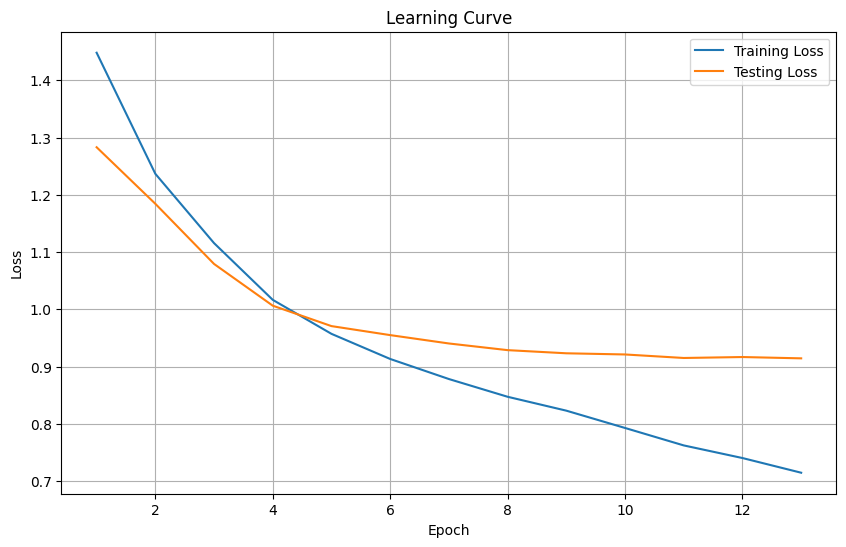

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store training and testing losses
train_losses = []
test_losses = []

# Training and evaluation loop
epochs = 13  # Number of epochs
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)  # Average loss for training
    train_losses.append(train_loss)

    # Testing phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            test_loss += loss.item()
    test_loss /= len(test_loader)  # Average loss for testing
    test_losses.append(test_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       174
           1       0.66      0.88      0.75       278
           2       0.42      0.10      0.16        49
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        22
           5       0.33      0.10      0.16        29

    accuracy                           0.69       572
   macro avg       0.37      0.32      0.31       572
weighted avg       0.61      0.69      0.63       572



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


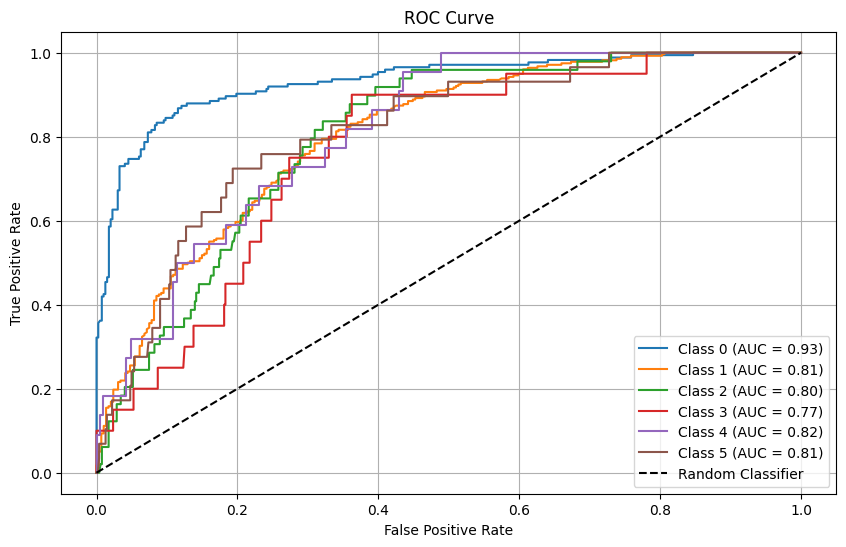

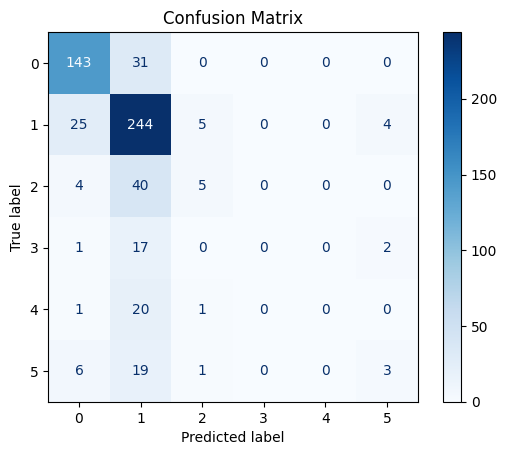

In [ ]:
evaluate_model(model, test_loader)


## Same model with class weights and more epochs

Normalized Class Weights: tensor([0.0324, 0.0218, 0.1171, 0.3737, 0.2738, 0.1811])
Epoch 1/200, Train Loss: 1.7903, Test Loss: 1.7888
Epoch 2/200, Train Loss: 1.7877, Test Loss: 1.7868
Epoch 3/200, Train Loss: 1.7843, Test Loss: 1.7844
Epoch 4/200, Train Loss: 1.7799, Test Loss: 1.7812
Epoch 5/200, Train Loss: 1.7748, Test Loss: 1.7770
Epoch 6/200, Train Loss: 1.7675, Test Loss: 1.7719
Epoch 7/200, Train Loss: 1.7609, Test Loss: 1.7657
Epoch 8/200, Train Loss: 1.7508, Test Loss: 1.7581
Epoch 9/200, Train Loss: 1.7417, Test Loss: 1.7498
Epoch 10/200, Train Loss: 1.7299, Test Loss: 1.7401
Epoch 11/200, Train Loss: 1.7167, Test Loss: 1.7294
Epoch 12/200, Train Loss: 1.7014, Test Loss: 1.7179
Epoch 13/200, Train Loss: 1.6859, Test Loss: 1.7056
Epoch 14/200, Train Loss: 1.6677, Test Loss: 1.6930
Epoch 15/200, Train Loss: 1.6487, Test Loss: 1.6801
Epoch 16/200, Train Loss: 1.6343, Test Loss: 1.6669
Epoch 17/200, Train Loss: 1.6127, Test Loss: 1.6538
Epoch 18/200, Train Loss: 1.5972, Test Los

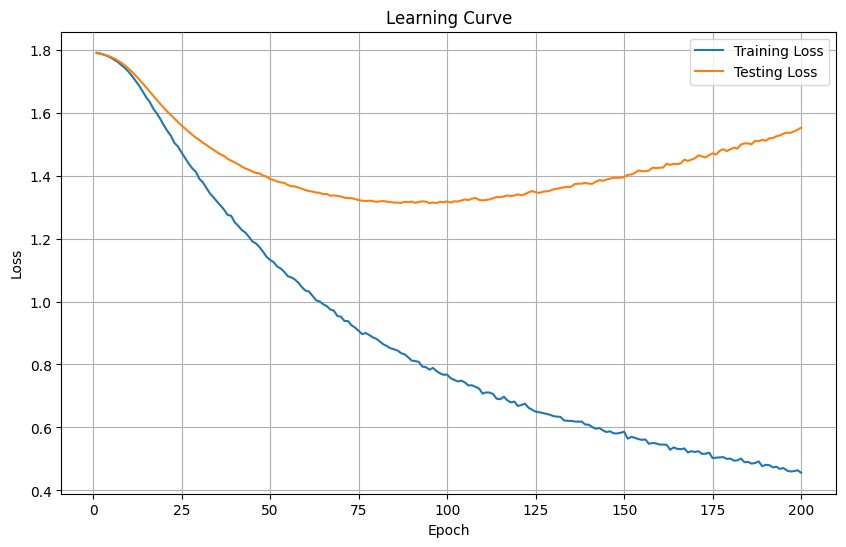

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

model2 = Sonar_Classifier(input_dim, hidden_dim, output_dim)

# Getting Class Weights
y_train_np = y_train_sonar.numpy()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(y_train_np),  # Unique classes in training labels
    y=y_train_np  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)

# Now passing these weight to loss function
criterion2 = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001) # Reduced from 0.001


# Initialize lists to store training and testing losses
train_losses_model2 = []
test_losses_model2 = []

# Training and evaluation loop
epochs = 200  # Number of epochs
for epoch in range(epochs):
    # Training phase
    model2.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = criterion2(outputs, y_batch.long())  # Ensure labels are long type
        loss.backward()
        # Prevent exploading gradients by clipping
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer2.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)  # Average loss for training
    train_losses_model2.append(train_loss)

    # Testing phase
    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model2(X_batch)
            loss = criterion2(outputs, y_batch.long())
            test_loss += loss.item()
    test_loss /= len(test_loader)  # Average loss for testing
    test_losses_model2.append(test_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot the learning curve
plt.close('all')  # Close all existing figures

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses_model2, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses_model2, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       174
           1       0.78      0.54      0.64       278
           2       0.19      0.33      0.24        49
           3       0.27      0.35      0.30        20
           4       0.27      0.36      0.31        22
           5       0.22      0.34      0.27        29

    accuracy                           0.60       572
   macro avg       0.42      0.47      0.43       572
weighted avg       0.67      0.60      0.62       572



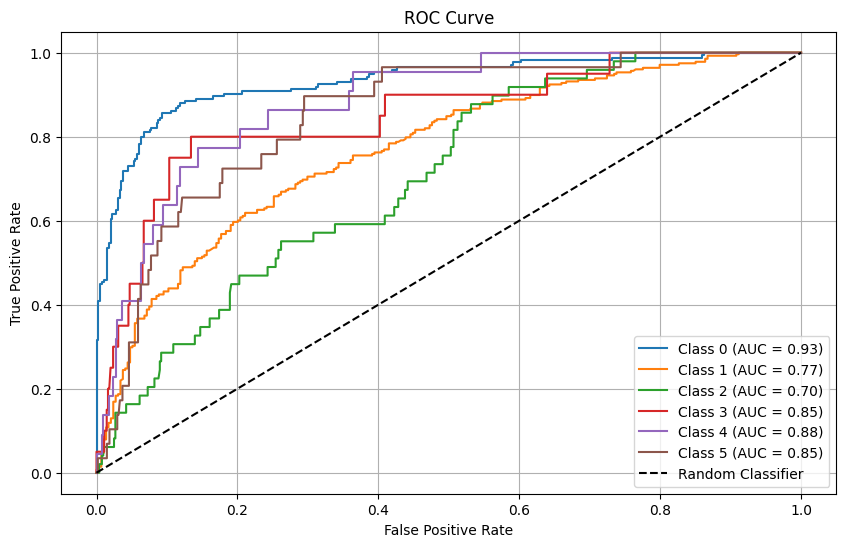

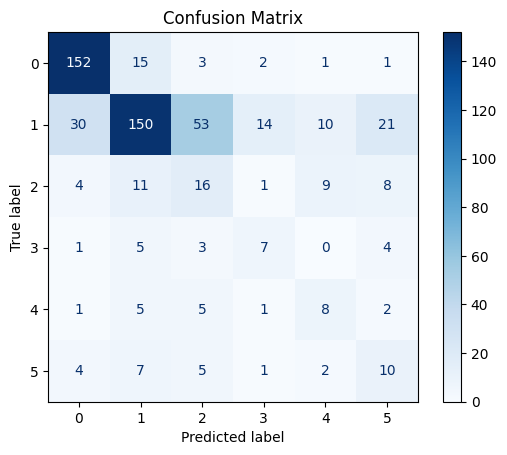

In [ ]:
evaluate_model(model2, test_loader)